In [1]:
from tqdm import tqdm
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import wandb
api = wandb.Api()

In [98]:
# Replace 'username/project_name' with your specific project path
# Composable_Interventions
project_paths = ['dri-ice/Composable_Interventions', 'dri-ice/AK_Tests']

filter_dict = {
    "config.edit": "ft",
    # "config.interventions": '[edit]',
    "state": "finished",
    # "tags": "None",
    # "config.compress": False,
    # "config.unlearn": "none",
    "created_at": {"$gte": "2024-05-15"}  # Use the correct date format
}
baseline_dict = {
    # "config.edit": "ft",
    # "config.interventions": '[edit]',
    "state": "finished",
    "tags": "None",
    "config.compress": False,
    "config.unlearn": "none",
    "created_at": {"$gte": "2024-05-15"}  # Use the correct date format
}
# List to store individual DataFrames
data_frames = []
for project_path in project_paths:
    runs = api.runs(project_path, filters=filter_dict)
    baseline_runs = api.runs(project_path, filters=baseline_dict)
    # Iterate over each run and capture the config and summary metrics
    for run in runs:
        config_frame = pd.DataFrame([run.config])
        summary_frame = pd.DataFrame([run.summary_metrics])
        combined_frame = pd.concat([config_frame, summary_frame], axis=1)
        data_frames.append(combined_frame)
    for run in baseline_runs:
        config_frame = pd.DataFrame([run.config])
        summary_frame = pd.DataFrame([run.summary_metrics])
        combined_frame = pd.concat([config_frame, summary_frame], axis=1)
        data_frames.append(combined_frame)
    # Concatenate all the individual DataFrames into a single DataFrame
    all_runs_df = pd.concat(data_frames, ignore_index=True)

# Display the DataFrame
# Sort by 'tag' and '_timestamp' in descending order to have the most recent run first
all_runs_df_sorted = all_runs_df.sort_values(by=['tag', '_timestamp'], ascending=[True, False])

# Drop duplicates, keeping only the first occurrence (which is the most recent due to sorting)
all_runs_df_deduplicated = all_runs_df_sorted.drop_duplicates(subset=['tag'], keep='first')

rename_dict = {
    "meta-llama/Meta-Llama-3-8B" : "Llama-3 (8b)",
    "ft" : "Fine-tune",
    "memit" : "MEMIT",
    "lora" : "Lora",
    "wanda" : "Wanda",
    "sparsegpt" : "SparseGPT",
    "gptq" : "GPTQ",
    "awq" : "AWQ",
    "rmu" : "RMU",
               }
metrics = all_runs_df_deduplicated
metrics["model_name"] = metrics["model_name"].apply(lambda x : rename_dict.get(x, None))
metrics["edit"] = metrics["edit"].apply(lambda x : rename_dict.get(x, None))
metrics["compression"] = metrics["compression"].apply(lambda x : rename_dict.get(x, None))
metrics["unlearn"] = metrics["unlearn"].apply(lambda x : rename_dict.get(x, None))
all_runs_df_deduplicated = metrics

/tmp/ipykernel_873551/2959351222.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics["model_name"] = metrics["model_name"].apply(lambda x : rename_dict.get(x, None))
/tmp/ipykernel_873551/2959351222.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics["edit"] = metrics["edit"].apply(lambda x : rename_dict.get(x, None))
/tmp/ipykernel_873551/2959351222.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [99]:
data = all_runs_df_deduplicated
# print(data['interventions'])
# Select rows where the 'interventions' column is exactly ['edit']
temp = data[data['interventions'].apply(lambda x: x == ['edit', 'compress'])]

categories = {
    "No Intervention": data[data['interventions'].apply(lambda x: x == [])].copy(),
    "Editing": data[data['interventions'].apply(lambda x: x == ['edit'])].copy(),
    "Compression": data[data['interventions'].apply(lambda x: x == ['compress'])].copy(),
    "Edit to Compression": data[data['interventions'].apply(lambda x: x == ['edit', 'compress'])].copy(),
    "Compression to Edit": data[data['interventions'].apply(lambda x: x == ['compress', 'edit'])].copy(),
    "Unlearn": data[data['interventions'].apply(lambda x: x == ['unlearn'])].copy(),
    "Edit to Unlearn": data[data['interventions'].apply(lambda x: x == ['edit', 'unlearn'])].copy(),
    "Unlearn to Edit": data[data['interventions'].apply(lambda x: x == ['unlearn', 'edit'])].copy(),
    "Compress to Unlearn": data[data['interventions'].apply(lambda x: x == ['compress', 'unlearn'])].copy(),
    "Unlearn to Compress": data[data['interventions'].apply(lambda x: x == ['unlearn', 'compress'])].copy()
}
categories['Edit to Unlearn']

,lr,tag,edit,save,seed,dtype,wandb,wbits,device,method,...,act_order,groupsize,zero_point,use_variant,quant_method,static_groups,true_sequential,wbit,prune_method,sparsity_type
1,0.00005,ft-rmu,Fine-tune,out/,42,torch.bfloat16,online,16.0,0,none,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
def format_flops(value):
    """ Format FLOPs with three significant figures and appropriate suffix. """
    try:
        if isinstance(value, str):
            value = clean_numeric_value(value)
        if abs(value) < 1e6:  # Less than 1 million (below Mega)
            return "{:.3g}k".format(value / 1e3)
        elif abs(value) < 1e9:  # Mega to Giga range
            return "{:.3g}M".format(value / 1e6)
        elif abs(value) < 1e12:  # Giga to Tera range
            return "{:.3g}G".format(value / 1e9)
        else:  # Tera and above
            return "{:.3g}T".format(value / 1e12)
    except Exception as e:
        print(f"Error formatting FLOPs value {value}: {e}")
        return "---"

def escape_latex_special_chars(s):
    """ Escape special characters in LaTeX strings. """
    return str(s).replace('%', '\\%').replace('_', '\\_').replace('&', '\\&').replace('#', '\\#').replace('$', '\\$')

def clean_numeric_value(value):
    """ Convert a string with units to a numeric value. """
    try:
        value = str(value)
        if ' TFLOPS' in value:
            return float(value.replace(' TFLOPS', '')) * 1e12
        if ' GFLOPS' in value:
            return float(value.replace(' GFLOPS', '')) * 1e9
        if ' MFLOPS' in value:
            return float(value.replace(' MFLOPS', '')) * 1e6
        if ' kFLOPS' in value:
            return float(value.replace(' kFLOPS', '')) * 1e3
        return pd.to_numeric(value, errors='coerce')
    except Exception as e:
        print(f"Error cleaning value {value}: {e}")
        return pd.NA

def categorize_and_generate_latex(data):
    # Define categories based on the provided criteria
    categories = {
    "No Intervention": data[data['interventions'].apply(lambda x: x == [])].copy(),
    "Editing": data[data['interventions'].apply(lambda x: x == ['edit'])].copy(),
    "Compression": data[data['interventions'].apply(lambda x: x == ['compress'])].copy(),
    "Edit to Compression": data[data['interventions'].apply(lambda x: x == ['edit', 'compress'])].copy(),
    "Compression to Edit": data[data['interventions'].apply(lambda x: x == ['compress', 'edit'])].copy(),
    "Unlearn": data[data['interventions'].apply(lambda x: x == ['unlearn'])].copy(),
    "Edit to Unlearn": data[data['interventions'].apply(lambda x: x == ['edit', 'unlearn'])].copy(),
    "Unlearn to Edit": data[data['interventions'].apply(lambda x: x == ['unlearn', 'edit'])].copy(),
    "Compress to Unlearn": data[data['interventions'].apply(lambda x: x == ['compress', 'unlearn'])].copy(),
    "Unlearn to Compress": data[data['interventions'].apply(lambda x: x == ['unlearn', 'compress'])].copy()
}
    # Clean numeric columns
    for col in ["FLOPs", "Latency"]:
        if col in data.columns:
            data.loc[:, col] = data[col].apply(clean_numeric_value)
            data.loc[:, col] = pd.to_numeric(data[col], errors='coerce')  # Ensure all values are numeric

    # Column mappings
    column_mappings = {
        "Success": "Rewrite accuracy",
        "Generalization": "Generalization",
        "Locality": "Locality",
        "Avg. Bits": "Average bits",
        "FLOPs": "FLOPs",
        "PPL": "PPL",
        "MMLU": "mmlu accuracy",
        "WMDP Bio": "wmdp_bio accuracy",
        "WMDP Cyber": "wmdp_cyber accuracy"
    }
    latex_columns = ["Success", "Generalization", "Locality", "Avg. Bits", "FLOPs", "PPL", "MMLU", "WMDP Bio", "WMDP Cyber"]

    # Initialize output string
    output_str = ""

    for category, group in categories.items():
        if group.empty:
            continue
        # output_str += f"\\textbf{{{category}}} \\\\ \\midline\n"
        for _, row in group.iterrows():
            # Calculate mean and std for each relevant column within the group
            stats = {}
            for latex_col, csv_col in column_mappings.items():
                if csv_col in row.index:
                    value = row[csv_col]
                    if pd.isna(value):
                        stats[latex_col] = "---"
                    else:
                        # Custom formatting for FLOPs and Latency
                        if latex_col == "FLOPs":
                            mean_str = format_flops(value)
                            stats[latex_col] = escape_latex_special_chars(mean_str)
                        elif latex_col == "Latency":
                            mean_str = f"{value:.3f}s"
                            stats[latex_col] = escape_latex_special_chars(mean_str)
                        else:
                            mean_str = f"{value:.3f}"
                            stats[latex_col] = escape_latex_special_chars(mean_str)
                else:
                    stats[latex_col] = "---"

            # Prepare the LaTeX row for the current group
            latex_row = escape_latex_special_chars(row['tag'])  # Use the tag name directly without escaping
            for column in latex_columns:
                latex_row += " & " + stats.get(column, "---")
            latex_row += " \\\\"

            # Append to output string
            output_str += latex_row + "\n"
        
        output_str += "\\midrule\n"

    return output_str

latex_rows_with_categories = categorize_and_generate_latex(all_runs_df_deduplicated)
print(latex_rows_with_categories)

None & 0.009 & 0.021 & 0.027 & 16.000 & 1.92T & 5.540 & 0.620 & 0.711 & 0.444 \\
\midrule
ft\_Edit & 0.980 & 0.726 & 0.142 & 16.000 & 1.92T & 5.565 & 0.618 & 0.704 & 0.441 \\
\midrule
ft-to-AWQ2bit & 0.000 & 0.000 & 0.000 & 2.250 & -0.001k & 1741892.125 & 0.269 & 0.240 & 0.246 \\
ft-to-AWQ4bit & 0.000 & 0.000 & 0.000 & 2.250 & -0.001k & 1741892.125 & 0.269 & 0.240 & 0.246 \\
ft-to-AWQ8bit & 0.000 & 0.000 & 0.000 & 2.250 & -0.001k & 1741892.125 & 0.269 & 0.240 & 0.246 \\
ft-to-GPTQ2bit & 0.795 & 0.642 & 0.174 & 4.250 & -0.001k & 9.343 & 0.592 & 0.679 & 0.436 \\
ft-to-GPTQ4bit & 0.701 & 0.671 & 0.133 & 4.250 & -0.001k & 9.422 & 0.584 & 0.656 & 0.427 \\
ft-to-GPTQ8bit & 0.701 & 0.671 & 0.133 & 4.250 & -0.001k & 9.422 & 0.584 & 0.656 & 0.427 \\
ft-to-SparseGPT0.25\% & 0.955 & 0.728 & 0.098 & 12.250 & 1.47T & 5.905 & 0.595 & 0.672 & 0.422 \\
ft-to-SparseGPT0.45\% & 0.625 & 0.497 & 0.076 & 9.250 & 1.12T & 7.480 & 0.529 & 0.597 & 0.395 \\
ft-to-SparseGPT0.65\% & 0.133 & 0.111 & 0.018 & 6.250 

/tmp/ipykernel_873551/1870216397.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, col] = data[col].apply(clean_numeric_value)
/tmp/ipykernel_873551/1870216397.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, col] = pd.to_numeric(data[col], errors='coerce')  # Ensure all values are numeric


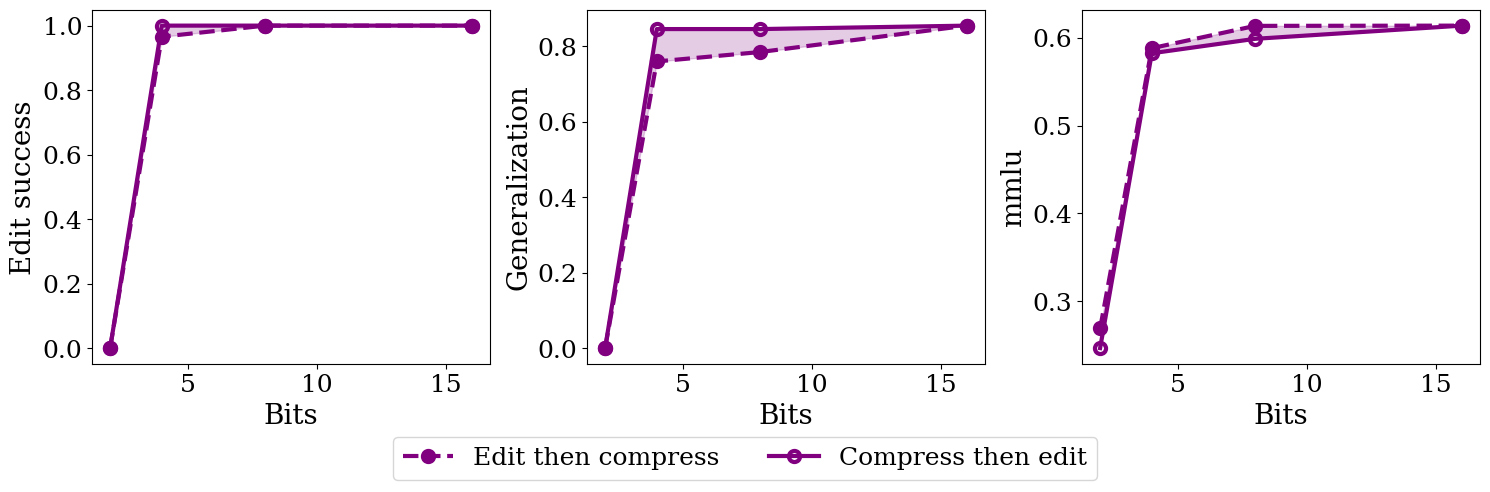

<Figure size 640x480 with 0 Axes>

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Set the font family to serif
plt.rcParams['font.family'] = 'serif'

# Assuming 'metrics' DataFrame is already loaded from the CSV

# Define the criteria for filtering
selected_method = 'AWQ'
edit_method = ["FT"]

# Filter based on the criteria
edit_then_compress = categories['Edit to Compression']
compress_then_edit = categories['Compression to Edit']

# Filter based on selected method
edit_then_compress = edit_then_compress[edit_then_compress['compression']==selected_method]
compress_then_edit = compress_then_edit[compress_then_edit['compression']==selected_method]

# Add baselines to dfs
baseline = categories['Editing']
baseline['wbits'] = 16
edit_then_compress = pd.concat([edit_then_compress, baseline], axis=0)
compress_then_edit = pd.concat([compress_then_edit, baseline], axis=0)

# Sort by 'wbits' in ascending order
edit_then_compress = edit_then_compress.sort_values(by='wbits')
compress_then_edit = compress_then_edit.sort_values(by='wbits')

# Define the metrics to plot
metrics_to_plot = ['Rewrite accuracy', 'Generalization', 'mmlu']
x_axis_metric = 'wbits'

# Compute baselines
# edit_then_compress_baselines = {model: edit_then_compress[(edit_then_compress['model_name'] == model) & (edit_then_compress['sparsity_ratio'] == 0)][metrics_to_plot].mean() for model in included_models}
# compress_then_edit_baselines = {model: compress_then_edit[(compress_then_edit['model_name'] == model) & (compress_then_edit['sparsity_ratio'] == 0)][metrics_to_plot].mean() for model in included_models}
# edit_then_compress_baselines = categories['No Intervention']
# compress_then_edit_baselines = categories['No Intervention']

# Define plot parameters
title_fontsize = 20
label_fontsize = 20
legend_fontsize = 18
tick_fontsize = 18
line_width = 3
marker_size = 8

# Create subplots
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(15, 5))

# Iterate over each metric and plot
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    
    # Plot the data with scatter and lines
    ax.plot(edit_then_compress['wbits'], edit_then_compress[metric], linestyle='--', marker='o', markerfacecolor='purple', color='purple', label='Edit then compress',
            linewidth=line_width, markersize=marker_size, markeredgewidth=line_width)
    ax.plot(compress_then_edit['wbits'], compress_then_edit[metric], linestyle='-', marker='o', markerfacecolor='none', color='purple', label='Compress then edit',
            linewidth=line_width, markersize=marker_size, markeredgewidth=line_width)
    
    # Fill the area between the lines
    ax.fill_between(edit_then_compress['wbits'], edit_then_compress[metric], compress_then_edit[metric], color='purple', alpha=0.2)
    
    # Integrate baselines into the scatter plots
    for model in included_models:
        baseline_edit = edit_then_compress_baselines[metric]
        baseline_compress = compress_then_edit_baselines[metric]
        
        if x_axis_metric == 'Average bits':
            baseline_x = 16
            ax.set_xlim(2, 16)
        elif x_axis_metric == 'sparsity_ratio':
            baseline_x = 0.0
            ax.set_xlim(0, 1)
        else:
            baseline_x = 0  # Adjust based on your default x-axis range

        # Add baselines to the scatter plots
        # ax.scatter([baseline_x], [baseline_edit], color='purple', marker='o', s=marker_size**2, edgecolor='purple', linewidth=line_width)
        # ax.scatter([baseline_x], [baseline_compress], color='purple', marker='o', s=marker_size**2, edgecolor='purple', linewidth=line_width)
    if x_axis_metric == 'wbits':
        ax.set_xlabel('Bits', fontsize=label_fontsize)
    else:
        ax.set_xlabel(x_axis_metric, fontsize=label_fontsize)
    if metric == 'Rewrite accuracy':
        ax.set_ylabel('Edit success', fontsize=label_fontsize)
    else:
        ax.set_ylabel(metric, fontsize=label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Move the legend to the bottom of the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize=legend_fontsize, ncol=2)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust the bottom margin to make space for the legend
plt.show()
plt.savefig('figures/memit-gptq.pdf', format='pdf')
